# Assignment 1

**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

## Table of contents

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)


## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
import warnings
import itertools
import subprocess
import psycopg2

import pandas            as pd
import numpy             as np
import statsmodels.api   as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools   import adfuller
from statsmodels.tsa.stattools   import acf, pacf
from statsmodels.tsa.seasonal    import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab            import rcParams
from sqlalchemy                  import create_engine
from datetime                    import datetime

%matplotlib inline

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

In [2]:
in_school = True

if (True == in_school):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url = 'https://pxl-ss.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = "pxl-ss"
    TABLE_NAME = "Temperature"

    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri = conn_info.stdout.decode('utf-8').strip()

    engine = create_engine(connuri)
    raw_engine = engine.raw_connection()

    data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)
    
print(data.head())

                      creation_date  id                          place  value
0  2018-11-10T23:38:44.453789+00:00   1  Lat:51.037460, Long: 5.301590  21.48
1  2018-11-10T23:53:53.134313+00:00   2  Lat:51.037460, Long: 5.301590  19.48
2  2018-11-10T23:53:57.457321+00:00   3  Lat:51.037460, Long: 5.301590  20.60
3  2018-11-10T23:56:10.690055+00:00   4  Lat:51.037460, Long: 5.301590  20.45
4  2018-11-10T23:58:49.577553+00:00   5  Lat:51.037460, Long: 5.301590  20.76


## Restructure the data to form a time series

The data we got from our source is has multiple tables we don't care about, we really only care about the 'creation_date' & 'value' column.<br>
We create a new pandas dataframe with only those 2 columns and rename them to a more human readable names: 'dateTime' & 'temperature'.

Afther renaming the columns we will have to convert them to the right data type. datetime for the 'dateTime' column and float for the 'temperature' column.

Since we are aiming to work with a time series we have to set the 'dateTime' column as the index.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 2 columns):
dateTime       272 non-null object
temperature    272 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 272 entries, 2018-11-10 23:38:44.453789 to 2018-11-13 09:55:13.824108
Data columns (total 1 columns):
temperature    272 non-null float64
dtypes: float64(1)
memory usage: 4.2 KB
None


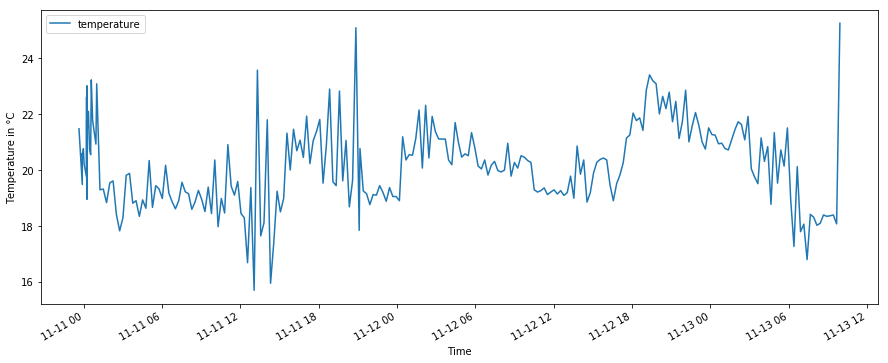

In [3]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Inspect data
print(df.info())

# Convert the creation_date column to datetime64
df['dateTime'] = pd.to_datetime(df['dateTime'])
# Convert the value column to float
df['temperature'] = pd.to_numeric(df['temperature'])

# Set the dateTime column as index
df.set_index('dateTime', inplace=True)

# Inspect data
print(df.info())

# Plot data
df.plot(figsize=(15, 6), label='Temperature')
plt.ylabel("Temperature in °C")
plt.xlabel("Time")
plt.show()

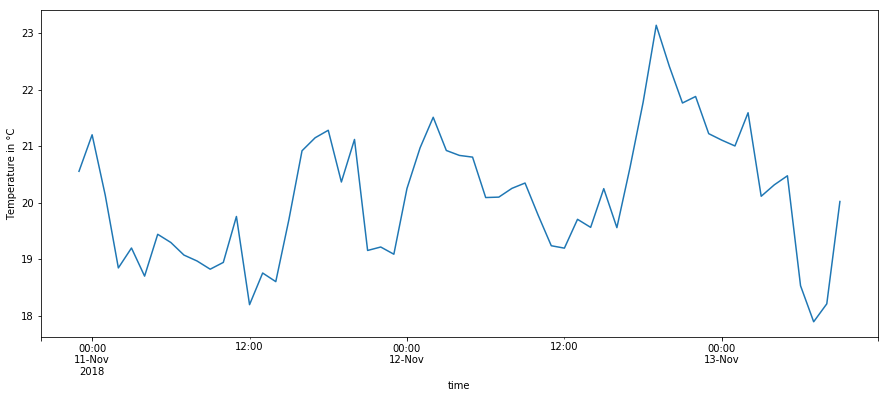

In [4]:
my_df = df['temperature'].resample('60T').mean()
my_df = my_df.fillna(my_df.bfill())

my_df.plot(figsize=(15, 6), label='temperature')
plt.ylabel("Temperature in °C")
plt.xlabel("time")
plt.show()

In [5]:
rolmean = my_df.rolling(window=24).mean()
rolstd = my_df.rolling(window=24).std()
print(rolmean,rolstd)

dateTime
2018-11-10 23:00:00          NaN
2018-11-11 00:00:00          NaN
2018-11-11 01:00:00          NaN
2018-11-11 02:00:00          NaN
2018-11-11 03:00:00          NaN
2018-11-11 04:00:00          NaN
2018-11-11 05:00:00          NaN
2018-11-11 06:00:00          NaN
2018-11-11 07:00:00          NaN
2018-11-11 08:00:00          NaN
2018-11-11 09:00:00          NaN
2018-11-11 10:00:00          NaN
2018-11-11 11:00:00          NaN
2018-11-11 12:00:00          NaN
2018-11-11 13:00:00          NaN
2018-11-11 14:00:00          NaN
2018-11-11 15:00:00          NaN
2018-11-11 16:00:00          NaN
2018-11-11 17:00:00          NaN
2018-11-11 18:00:00          NaN
2018-11-11 19:00:00          NaN
2018-11-11 20:00:00          NaN
2018-11-11 21:00:00          NaN
2018-11-11 22:00:00    19.640552
2018-11-11 23:00:00    19.579448
2018-11-12 00:00:00    19.539854
2018-11-12 01:00:00    19.574750
2018-11-12 02:00:00    19.685792
2018-11-12 03:00:00    19.757667
2018-11-12 04:00:00    19.846625
2

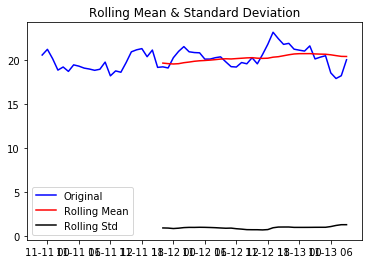

In [6]:
orig = plt.plot(my_df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(my_df, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -2.824191
p-value                         0.054900
#Lags Used                      0.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


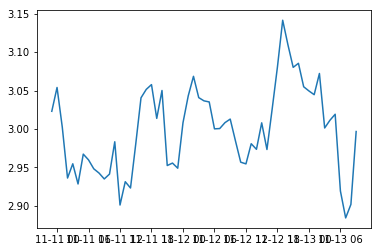

In [8]:
#Estimating trend
my_df_logScale = np.log(my_df)
plt.plot(my_df_logScale)

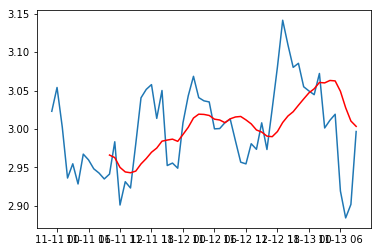

In [9]:
movingAverage = my_df_logScale.rolling(window=12).mean()
movingSTD = my_df_logScale.rolling(window=12).std()
plt.plot(my_df_logScale)
plt.plot(movingAverage, color='red')

In [11]:
datasetLogScaleMinusMovingAverage = my_df_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

dateTime
2018-11-11 10:00:00   -0.024723
2018-11-11 11:00:00    0.020580
2018-11-11 12:00:00   -0.048941
2018-11-11 13:00:00   -0.012721
2018-11-11 14:00:00   -0.019806
2018-11-11 15:00:00    0.035363
2018-11-11 16:00:00    0.085992
2018-11-11 17:00:00    0.089912
2018-11-11 18:00:00    0.087998
2018-11-11 19:00:00    0.038584
Freq: 60T, Name: temperature, dtype: float64

In [14]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

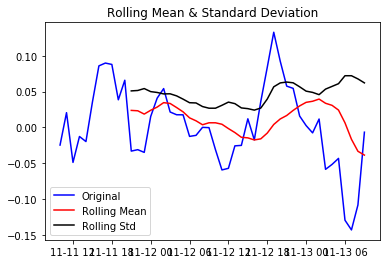

Results of Dickey Fuller Test:
Test Statistic                 -3.451059
p-value                         0.009337
#Lags Used                      2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [15]:
test_stationarity(datasetLogScaleMinusMovingAverage)